<a href="https://colab.research.google.com/github/ayshaw/Dog-Breed-Project/blob/master/generating_xtrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import package, load google drive, load file_type

In [1]:
%reset -f
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pylab as plt
import matplotlib.image as mping
import os
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import multiprocessing
import cv2
from keras.utils import to_categorical
print(multiprocessing.cpu_count())
# Imports keras
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

from keras.applications import resnet50
!nvidia-smi
!ls "/content/drive/My Drive/"
os.chdir('/content/drive/My Drive/')
file_type=pd.read_csv('ds_all.csv',index_col=0)
file_type.head()


Using TensorFlow backend.


2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Wed Dec 12 06:25:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|=============================

,filename,type,annotations,breed,breed_class,ymin,ymax,xmin,xmax,train/test
0,n02085620-Chihuahua/n02085620_10074.jpg,1,Annotation/n02085620-Chihuahua/n02085620_10074,Chihuahua,Toy Group,10.0,498.0,25.0,276.0,test
1,n02085620-Chihuahua/n02085620_10131.jpg,1,Annotation/n02085620-Chihuahua/n02085620_10131,Chihuahua,Toy Group,9.0,493.0,49.0,393.0,test
2,n02085620-Chihuahua/n02085620_10621.jpg,1,Annotation/n02085620-Chihuahua/n02085620_10621,Chihuahua,Toy Group,43.0,250.0,142.0,335.0,train
3,n02085620-Chihuahua/n02085620_1073.jpg,1,Annotation/n02085620-Chihuahua/n02085620_1073,Chihuahua,Toy Group,27.0,498.0,0.0,312.0,test
4,n02085620-Chihuahua/n02085620_10976.jpg,1,Annotation/n02085620-Chihuahua/n02085620_10976,Chihuahua,Toy Group,104.0,452.0,90.0,242.0,train


# generate x_train_all, shuffle, scale and save out scaled file

In [0]:
# for start in np.array([0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000]):
#   end=start+1000
#   print(start)
#   x_train=np.empty((250,250,3,end-start),dtype='uint8')
#   for index,row in file_type.loc[file_type['train/test']=='train'].reset_index().iloc[start:end,:].iterrows():
#     print(index)
#     x_train[:,:,:,index-start]=cv2.imread('Images_scaled/'+row['filename'])
#   np.save("x_train_"+str(start)+'_'+str(end), x_train)
#   x_train=None
#   del x_train

In [0]:
x_train_all = np.concatenate([np.load('x_train_0_1000.npy'),
                              np.load('x_train_1000_2000.npy'),
                              np.load('x_train_2000_3000.npy'),
                              np.load('x_train_3000_4000.npy'),
                              np.load('x_train_4000_5000.npy'),
                              np.load('x_train_5000_6000.npy'),
                              np.load('x_train_6000_7000.npy'),
                              np.load('x_train_7000_8000.npy'),
                              np.load('x_train_8000_9000.npy'),
                              np.load('x_train_9000_10000.npy'),
                              np.load('x_train_10000_11000.npy'),
                              np.load('x_train_11000_12000.npy')],
                              axis=3)
np.save('x_train_all',x_train_all)

## shuffle both x_train and y_train

In [0]:
# shuffle the x_train 
x_train_all=np.load('x_train_all.npy')
shuffle_index=np.random.randint(12000, size=12000)
np.save('shuffle_index',shuffle_index)
x_train_shuffled=x_train_all[:,:,:,shuffle_index]
np.save('x_train_shuffled',x_train_shuffled)

### make y_train

In [0]:
import keras
from keras.utils import to_categorical
shuffle_index=np.load('shuffle_index.npy')
file_type=pd.read_csv('ds_all.csv')
y_train=file_type.loc[file_type['train/test']=='train','breed_class'].values[shuffle_index]
np.save('y_train_strings',y_train)
y_ = np.load('y_train_strings.npy')
b_classes=pd.read_csv('ds_all.csv')['breed_class'].unique()
class_to_num = {}
for tick_class,b_class in enumerate(b_classes):
  class_to_num[b_class] = tick_class
  y_[y_==b_class] = tick_class
np.save('class_to_num',class_to_num)
np.save('y_train_number',y_)
np.save('y_train_categorical',keras.utils.to_categorical(y_))

## scale x_train
To prevent the restarting of each session, I will have to delete everything and reload it again!

In [0]:
# %reset -f

# import matplotlib.pylab as plt
# import os
# import pandas as pd
# import numpy as np
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# !nvidia-smi
# !ls "/content/drive/My Drive/"
# os.chdir('/content/drive/My Drive/')

# # standardize the channels for x_train
# x_train_scaled = np.load('x_train_shuffled.npy').astype('float16')
# for i in range(12000):
#   x_train_scaled[:,:,:,i] = x_train_scaled[:,:,:,i]/255
# np.save('x_train_scaled_16',x_train_scaled)

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Wed Dec 12 04:49:37 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------------------------

## save out x_train_scaled

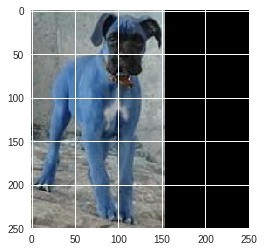

In [0]:
plt.imshow(x_train_scaled[:,:,:,11].astype('float'))

### test x_train_scaled, y_train_scaled

{'Toy Group': 0, 'Hound Group': 1, 'Sporting Group': 2, 'Terrier Group': 3, 'Non-Sporting Group': 4, 'Working Group': 5, 'Herding Group': 6, 'Foundation Stock Service': 7, 'Hybrid': 8, 'NAN': 9}


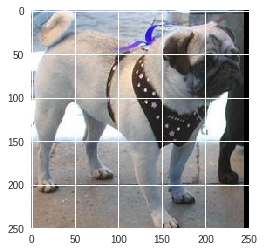

In [28]:
# plot x_train_scaled
num=8

plt.imshow(np.load('x_train_scaled_16.npy')[:,:,:,num].astype('float'))
print(np.load('class_to_num.npy').tolist())

In [30]:
np.argwhere(np.load('y_train_number.npy')==0)[1]
np.load('y_train_categorical.npy')[np.argwhere(np.load('y_train_number.npy')==0)[1]]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## resave out x_train_scaled after normalizing

In [0]:
# x_train_scaled=np.load('x_train_scaled.npy')
# np.save('x_train_normalized',x_train_scaled/255)

# generate x_test, scale and save out scaled file

In [0]:
%reset -f
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

from keras.applications import resnet50
!nvidia-smi
!ls "/content/drive/My Drive/"
os.chdir('/content/drive/My Drive/')
file_type=pd.read_csv('ds_all.csv',index_col=0)
file_type.head()
for start in np.array([8000]):
  if start == 8000:
    end=8580
  else:
    end=start+1000
  print(start)
  x_test=np.empty((250,250,3,end-start),dtype='uint8')
  for index,row in file_type.loc[file_type['train/test']=='test'].reset_index().iloc[start:end,:].iterrows():
    print(index)
    x_test[:,:,:,index-start]=cv2.imread('Images_scaled/'+row['filename'])
  np.save("x_test_"+str(start)+'_'+str(end), x_test)
  x_test=None
  del x_test

In [0]:
x_test_all = np.concatenate([np.load('x_test_0_1000.npy'),
                              np.load('x_test_1000_2000.npy'),
                              np.load('x_test_2000_3000.npy'),
                              np.load('x_test_3000_4000.npy'),
                              np.load('x_test_4000_5000.npy'),
                              np.load('x_test_5000_6000.npy'),
                              np.load('x_test_6000_7000.npy'),
                              np.load('x_test_7000_8000.npy'),
                              np.load('x_test_8000_8580.npy')],
                              axis=3)
np.save('x_test_all',x_test_all)


### scale x_test

In [0]:
#standardize the channels for x_test
x_test_scaled = np.load('x_test_all.npy').astype('float16')
for i in range(8580):
  x_test_scaled[:,:,:,i] = x_test_scaled[:,:,:,i]/255
np.save('x_test_scaled_16',x_test_scaled)

### make y_test

In [27]:
import keras
from keras.utils import to_categorical
file_type=pd.read_csv('ds_all.csv')
y_test=file_type.loc[file_type['train/test']=='test','breed_class'].values
np.save('y_test_strings',y_test)
class_to_num=np.load('class_to_num.npy')
y_ = np.load('y_test_strings.npy')
b_classes=pd.read_csv('ds_all.csv')['breed_class'].unique()
for tick_class,b_class in enumerate(b_classes):
  y_[y_==b_class] = class_to_num.tolist()[b_class]
np.save('y_test_number',y_)
np.save('y_test_categorical',keras.utils.to_categorical(y_))
class_to_num.tolist()

{'Foundation Stock Service': 7,
 'Herding Group': 6,
 'Hound Group': 1,
 'Hybrid': 8,
 'NAN': 9,
 'Non-Sporting Group': 4,
 'Sporting Group': 2,
 'Terrier Group': 3,
 'Toy Group': 0,
 'Working Group': 5}

0

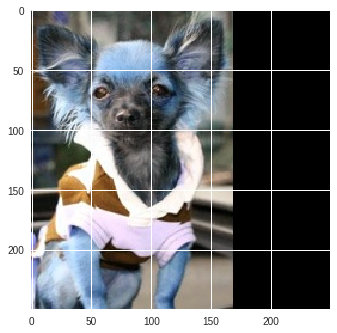

In [30]:
import matplotlib.pyplot as plt
plt.imshow(x_test_scaled[:,:,:,34].astype('float'))
np.load('y_test_number.npy')[34]